# Семинар 11: обработка звука

## Вступление
Сегодня мы изучим один из методов решения задачи автоматического распознавания речи (automatic speech recognition, ASR). Мы рассмотрим простой пример с распознаванием чисел, потому что у нас ограниченные вычислительные ресурсы. Однако такая задача возникает в самых разных проявлениях, например, в голосовых помощниках.

### План семинара:
1. Обработка данных
    1. Создание датасета
    2. Паддинг
    3. Вычисление признаков
2. Пишем простенькую модель
3. Имплементируем метрику качества
4. Обучение
5. Что дальше?

In [2]:
# Скачайте архив numbers.zip по ссылке https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P
# и положите разархивированные данные рядом с ноутбуком

# При работе в колабе загрузите его на гугл диск, например, путь
# '/content/drive/MyDrive/Colab Notebooks/sem11_audio/numbers.zip'

# !cp '/content/drive/MyDrive/Colab Notebooks/sem11_audio/numbers.zip' numbers.zip
# !unzip numbers.zip -d data/

# !pip install torchaudio
# !pip install Levenshtein

In [3]:
import os
from collections import defaultdict
from itertools import islice
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchaudio
from IPython import display
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.auto import trange

## 1. Обработка данных

Скачаем датасет с числами от 0 до 999_999, произнесенных на русском языке. В нём есть разные спикеры разного возраста и пола.

В целом, процесс преобразоания данных будет идти по такому пайплайну:
- На вход получаем .wav аудиосигналы — одномерные векторы последовательности амлитуд звуковой волны (вейвформы).
- По вейвформе мы проходимся окном фиксированного размера с фиксированным шагом и получаем набор аудиофреймов. Аудиофреймы обычно строят так, чтобы они довольно сильно пересекались.
- Для каждого аудиофрейма вычисляем вклад различных частот (в виде вектора) при помощи [дискретного преобразования Фурье](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5#%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%87%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) (discrete Fourier transform, DFT), которое, в свою очередь, вычисляется при помощи алгоритма [быстрого преобразования Фурье](https://ru.wikipedia.org/wiki/%D0%91%D1%8B%D1%81%D1%82%D1%80%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5) (fast Fourier transform, FFT).
- Композиция вкладов частот для каждого аудифрейма называется **спектрограммой**, которая является двумерной матрицей (по одной оси время, по второй — частоты).
- Поскольку в спектрограмме обычно считают преобладание 8000 частот (бывает больше, бывает меньше), то она получается довольно большого размера, что трудоёмеко для вычислений (да и такая точность не очень нужна). Поэтому финальным шагом к ней применяют преобразование, чтобы получить [**мел спектрограмму**](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BB_(%D0%B2%D1%8B%D1%81%D0%BE%D1%82%D0%B0_%D0%B7%D0%B2%D1%83%D0%BA%D0%B0)) (mel scale). Мел спектрограмма обычно имеет вклад порядка 80 частот (получаются из предыдущих взвешенными суммами по бинам), которые имеют другой масштаб единиц измерения и больше подходят для описания голоса для человеческого слуха.

In [4]:
# !wget https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py

### 1.1. Создание датасета
Переведём все аудиозаписи к одинаковому `sample_rate=16000`, а ответы — к нужному нам виду. Например, если произносится число 123, то приводим ответ к виду `y = [1,2,3]`.

In [5]:
class SpeechDataset(Dataset):
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = "numbers"

    def __init__(self, path_to_csv: str) -> None:
        self.path_to_csv = path_to_csv
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))
        return torch.LongTensor(digits)

    def __getitem__(self, index: int) -> dict[str, Any]:
        output = self.csv.iloc[index]

        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            (path,) = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)

        wav = wav.squeeze()
        instance = {"path": path, "x": wav, "y": y}

        return instance

    def __len__(self) -> int:
        return self.csv.shape[0]

In [6]:
dataset = SpeechDataset("numbers/train.csv")

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

random_indexes = torch.randperm(len(dataset)).tolist()
train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [7]:
len(train_dataset), len(val_dataset)

(8100, 900)

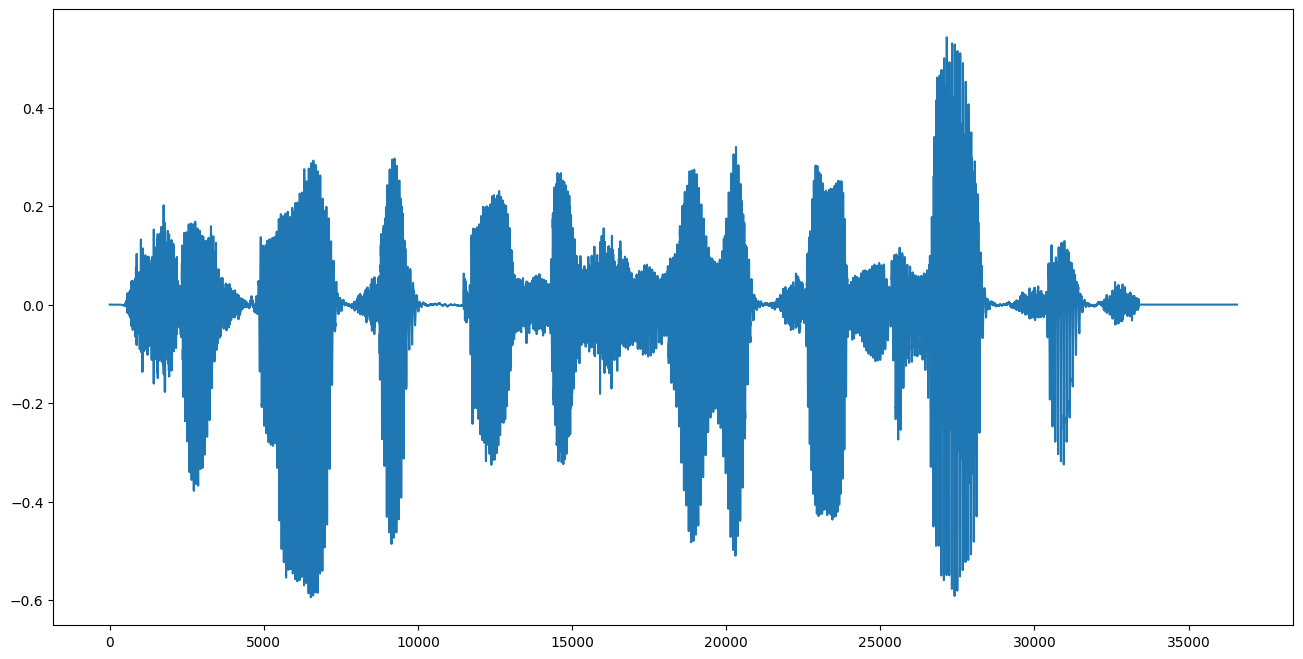

In [8]:
instance = train_dataset[0]
plt.figure(figsize=(16, 8))
plt.plot(instance["x"])

display.Audio(instance["x"], rate=dataset.SAMPLE_RATE)

In [9]:
instance["y"]

tensor([1, 6, 9, 2, 0])

### 1.2. Паддинг
В датасете числа от 0 до 999999. Для упаковки батчей нам необходимо, чтобы все ответы $y$ были одинаковой длины. Если число короче шести знаков, то оставшиеся ячейки заполняем '10':

123456 -> y = [1,2,3,4,5,6]

123    -> y = [1,2,3,10,10,10]

In [10]:
class PaddingCollator:
    def __call__(self, instances) -> dict[str, Any]:
        batch_size = len(instances)
        x_len = torch.LongTensor([instance["x"].size(0) for instance in instances])
        y_len = torch.LongTensor([instance["y"].size(0) for instance in instances])
        path = [instance["path"] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- паддинг

        for i, instance in enumerate(instances):
            x[i, : x_len[i]] = instance["x"]
            y[i, : y_len[i]] = instance["y"]

        instance = {"x": x, "y": y, "x_len": x_len, "y_len": y_len, "path": path}

        return instance

In [11]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    collate_fn=PaddingCollator(),
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=PaddingCollator(), pin_memory=True
)

In [12]:
batch = list(islice(val_dataloader, 1))[0]
batch

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'y': tensor([[ 4,  6,  0,  1,  2, 10],
         [ 8,  8,  3,  5,  4,  9],
         [ 1,  1,  7,  0,  8,  4],
         [ 6,  1,  5,  7,  2,  8],
         [ 4,  7,  4,  3,  1,  2],
         [ 4,  3,  3,  4,  5,  4],
         [ 9,  6,  7,  5,  9,  2],
         [ 5,  2,  6,  8,  8,  2],
         [ 2,  2,  1,  4,  2,  3],
         [ 9,  8,  9,  8,  5,  4],
         [ 9,  0,  5,  6,  8,  6],
         [ 5,  6,  1,  3,  2,  8],
         [ 9,  1,  2,  7,  0,  5],
         [ 8,  1,  6,  6,  6,  6],
         [ 3,  9,  3,  3,  6,  8],
         [ 8,  8,  8,  7,  2,  9],
         [ 6,  4,  5,  7,  0,  9],
         [ 4,  0,  8,  2,  5,  7],
         [ 5,  6,  7,  1,  5,  2],
         [ 2,  9,  6,  8,  9,  2],
         [ 8,  0,  1,  9,  5

### 1.3. Вычисление признаков

**Идея**: нарезаем сигнал на кусочки, и для каждого кусочка делаем преобразование Фурье и вычисляем его мел-спектрограмму.
Подробнее:
- О преобразовании Фурье: https://proglib.io/p/fourier-transform/
- О параметрах мел-спектрограммы: https://rdrr.io/cran/torchaudio/man/transform_mel_spectrogram.html

Нарезаем сигнал на кусочки:

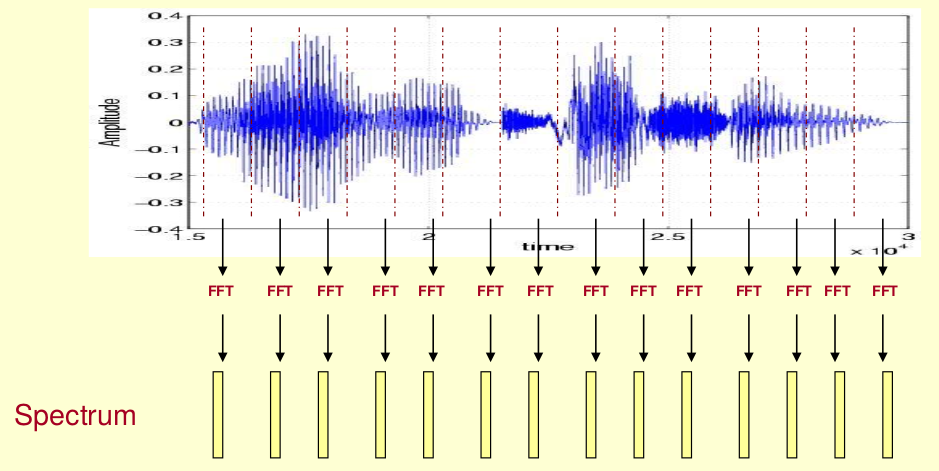

Для каждого кусочка получаем спектрограмму, и затем мел-спектрограмму:

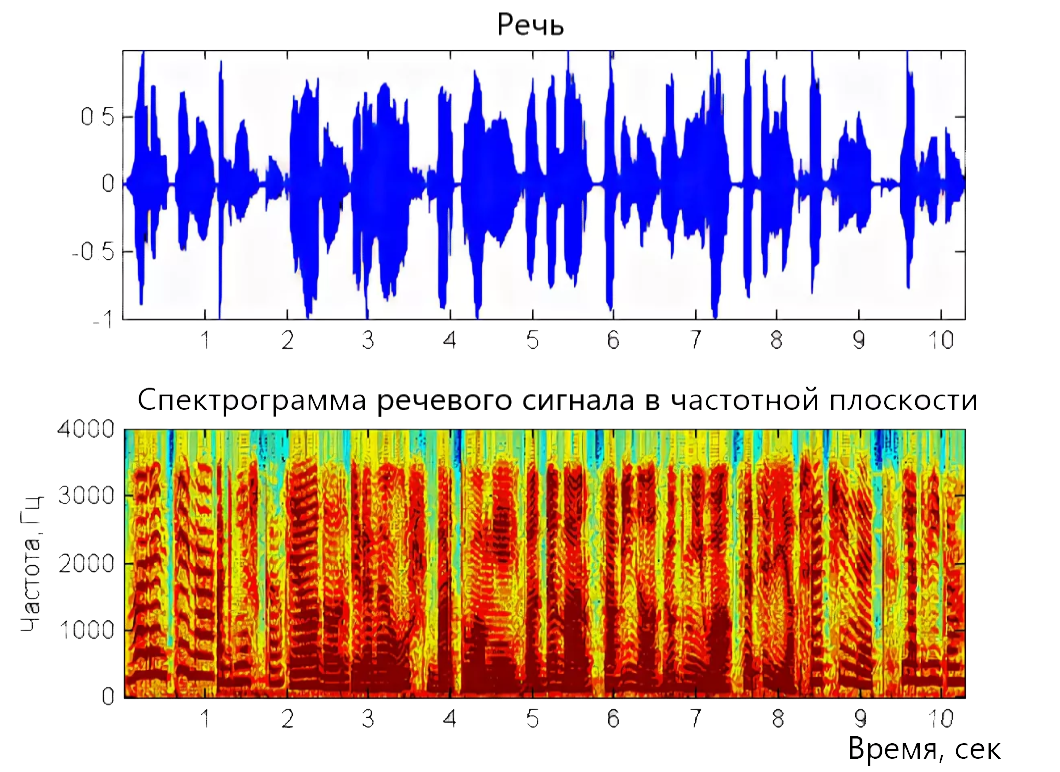

Пример получения спектрограммы по сигналу:
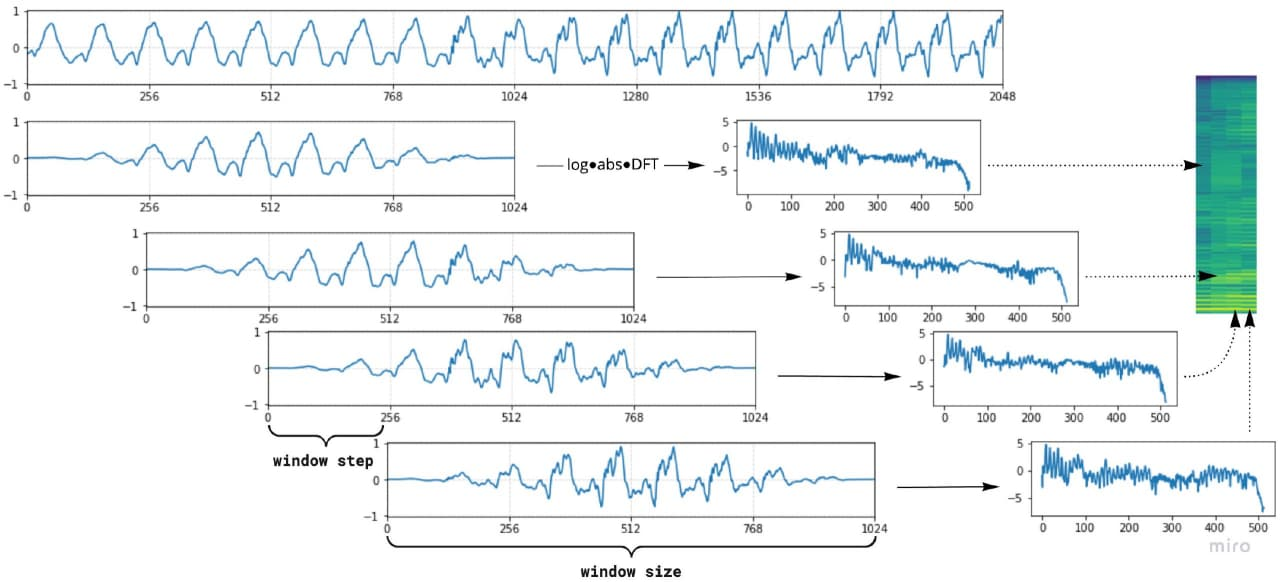

In [13]:
instance = train_dataset[31]
wav = instance["x"]

In [14]:
from torchaudio.transforms import MelSpectrogram

featurizer = MelSpectrogram(
    sample_rate=train_dataset.dataset.SAMPLE_RATE,
    n_fft=512,
    win_length=512,
    hop_length=512,
    n_mels=64,
    power=1,
)


def apply_compression(melspec):
    # Добавляем eps=1e-7 чтобы избежать log(0)
    return torch.log(melspec.clamp(1e-5))

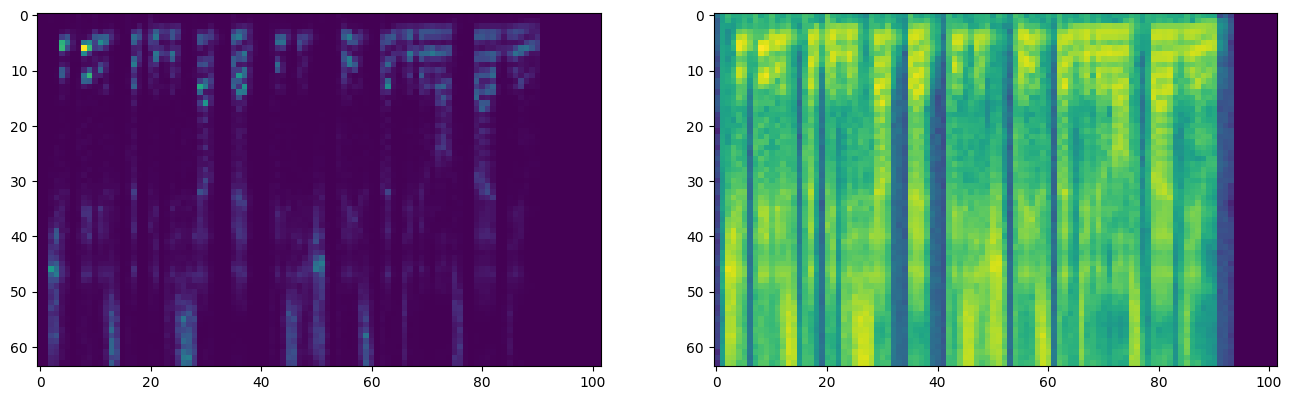

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(featurizer(wav))
axes[1].imshow(apply_compression(featurizer(wav)));

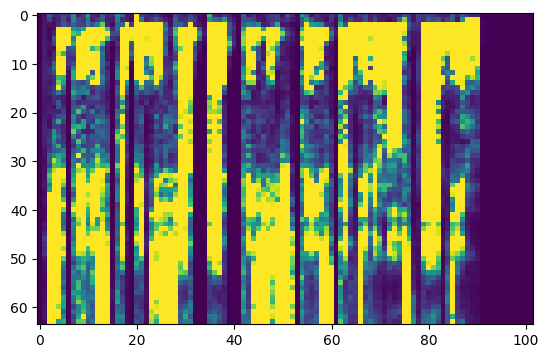

In [16]:
# Аугментация мел-спектрограммы
effects = [
    ["gain", "-n"],  # normalises to 0dB
    ["pitch", "5"],  # 5 cent pitch shift
]
waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    featurizer(wav).cpu(), 16000, effects, channels_first=True
)
plt.imshow(waveform);

In [17]:
class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=512,
            win_length=512,
            hop_length=512,
            n_mels=64,
            power=1,
        )

    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)

        # Переводим длинну из wav размера в melSpec размер
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len

        return x

## 2. Пишем простенькую модель

Напишем простую и маленькую модель на основе [QuartzNet](https://arxiv.org/pdf/1910.10261.pdf).

In [18]:
class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times

    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 4,
    ) -> None:
        super().__init__()

        self.repeat = repeat
        self.blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Conv1d(
                            in_channels=in_channels if i == 0 else hidden_channels,
                            out_channels=hidden_channels,
                            kernel_size=kernel_size,
                            groups=in_channels if i == 0 else hidden_channels,
                            padding=kernel_size // 2,
                            bias=False,
                        ),
                        nn.Conv1d(
                            hidden_channels, hidden_channels, kernel_size=1, bias=False
                        ),
                        nn.BatchNorm1d(hidden_channels),
                        nn.ReLU(),
                        nn.Dropout(p=0.2, inplace=False),
                    ]
                )
                for i in range(repeat)
            ]
        )
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_initial = x

        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j == (len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x

In [19]:
class DummyModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels) -> None:
        super().__init__()

        self.prenet = nn.Sequential(
            nn.Conv1d(
                in_channels, hidden_channels, 33, padding=33 // 2, stride=2, bias=False
            ),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
        )

        self.net = nn.Sequential(
            QuartzBlock(hidden_channels, hidden_channels),
            QuartzBlock(hidden_channels, hidden_channels * 2),
            nn.Conv1d(
                hidden_channels * 2,
                hidden_channels * 2,
                33,
                padding=33 // 2,
                stride=2,
                bias=False,
            ),
            nn.Conv1d(
                hidden_channels * 2, hidden_channels * 2, kernel_size=1, bias=False
            ),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            QuartzBlock(hidden_channels * 2, hidden_channels * 4),
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1, bias=False),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x: torch.Tensor, x_len: int) -> tuple[torch.Tensor, int]:
        x = self.prenet(x)
        x = self.net(x)

        return self.classifier(x), x_len // 4

## 3. Имплементируем метрику качества

В качестве метрики качества будем использовать [CER (character error rate)](https://huggingface.co/spaces/evaluate-metric/cer). По сути это доля неверно угаданных символов в ответе. Если смотреть чуть подробнее, то это расстояние Левенштейна между предсказанием и рефернсом (таргетом, ground truth), поделённое на длину референса. По [ссылке](https://www.rev.ai/blog/how-to-calculate-word-error-rate/) можете посмотреть на пример вычисления аналогичной метрики, но по словам (WER, word error rate).

Для вычисления CTC-loss необходимо сделать предобработку предсказния: убрать повторяющиеся символы и blank-символы.

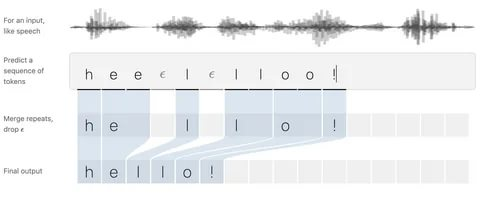

In [20]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    """
    Декодируем гипотезы
        1) Убираем повторяющиеся буквы
        2) Удаляем blank символы
    """
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = "".join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    """
    Считаем расстояние Левенштейна между предсказаниями и GT
    """

    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(target + "\t\t" + decoding)

    return cer / len(target), pairs

## 4. Обучение

In [21]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
NUM_EPOCH = 20
DEVICE = torch.device("cuda:0")

model = DummyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [23]:
history = defaultdict(list)

Epoch: 19
Example of prediction:  674990 -> 674990545
Example of prediction:  573111 -> 57311196563678
Example of prediction:  404102 -> 4040102523538458
Example of prediction:  925820 -> 9258207354367
Example of prediction:  962511 -> 962511963768


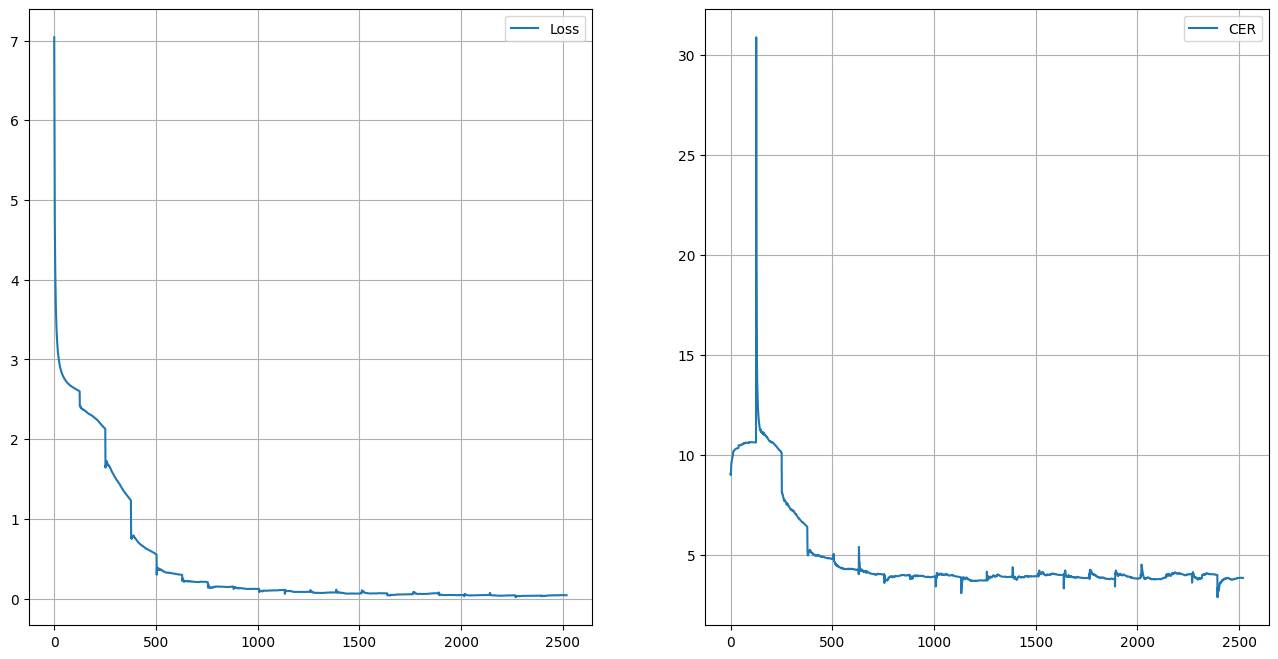

In [24]:
effects = [
    ["gain", "-n"],  # normalises to 0dB
    ["pitch", "5"],  # 5 cent pitch shift
]

for epoch in trange(NUM_EPOCH):
    average_cer = AverageMeter()
    average_loss = AverageMeter()

    for batch in train_dataloader:
        x = batch["x"].to(DEVICE)
        y = batch["y"].to(DEVICE)
        x_len = batch["x_len"].to(DEVICE)
        y_len = batch["y_len"].to(DEVICE)

        x, x_len = mel_featurizer(x, x_len)

        # здесь можно добавить аугментацию

        batch_size = x.shape[2]
        for i in range(batch_size // 2):
            if i % 2 == 0:
                # аугментация из torchaudio
                tmp, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
                    x[:, :, i].cpu(), 16000, effects
                )
                x[:, :, i] = tmp.to(DEVICE)

        log_probs, x_len = model(x, x_len)

        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history["loss"].append(average_loss.avg)
        history["cer"].append(average_cer.avg)

    display.clear_output()
    print(f"Epoch: {epoch}")
    for i in range(5):
        print(f"Example of prediction: ", pairs[i].replace("\t\t", " -> "))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history["loss"], label="Loss")
    axes[1].plot(history["cer"], label="CER")
    axes[0].legend()
    axes[0].grid()
    axes[1].legend()
    axes[1].grid()
    plt.show()

## 5. Что дальше?

1. Добавить аугментацию! Например, аугментация [SpecAug](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/).
2. Улучшить модель. Например, еще больше уменьшить временное пространство. Сейчас мы его уменьшаем в 4 раза, но это все равно мало так как длина GT строк 4-6.
3. Перевести цифры в буквы и учить распознавание на буквах.
4. Добавить спец символ, которым разделяем разряды: тысячи/сотни.
5. Stack more layers :)